## MMSB: Implementation

In [1]:
from datetime import datetime

from IPython.core.debugger import Tracer
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.special import digamma, gammaln

%matplotlib inline
matplotlib.style.use('ggplot')
tracer = Tracer()

import warnings
warnings.filterwarnings('error')

In [2]:
def gen_data(B, V, N, alpha=0.1):
    assert B.shape[0] == B.shape[1]
    K = B.shape[0]
    alpha_vec = [alpha for _ in xrange(K)]
    
    pi = np.zeros((V, K))
    X = np.zeros((N, 3), dtype=int)
    for p in xrange(V):
        pi[p] = np.random.dirichlet(alpha_vec)
    
    for n in xrange(N):
        p = q = np.random.randint(V)
        while p == q:
            q = np.random.randint(V)
        
        p, q = sorted([p, q])
        g = np.random.choice(range(K), p=pi[p])
        h = np.random.choice(range(K), p=pi[q])
        y = np.random.binomial(1, p=B[g,h])
        X[n,:] = np.array([p,q,y])
        
    return X, pi

def make_B(K, probs=[.2]):
    B = np.eye(K) / 2. # 0.5 on diagonal
    for g in xrange(B.shape[0]):
        for h in xrange(g): # h < g, lower triangle
            B[h,g] = np.random.choice(probs)
            B[g,h] = 1 - B[h,g]
    return B

def get_interactions(X, V):
    I = np.zeros((V, V), dtype=int)
    for p, q, v in X:
        if v:
            I[p,q] += 1
        else:
            I[q,p] += 1
            
    for p in xrange(V):
        for q in xrange(p):
            if I[p,q] > I[q,p]:
                I[p,q] = 1
                I[q,p] = 0
            else:
                I[p,q] = 0
                I[q,p] = 1
    return I

In [13]:
def train_mmsb(X, K, n_iter=300):
    """X is an Nx3 matrix. Each row has the format:
    [smallIndex, bigIndex, bool(smallIndex -> bigIndex)]
    """
    # Hyperparameters

    N = X.shape[0] # Number of interactions
#     V = len(set(X[:,1]).union(set([X[:,1]]))) # Number of items
    V = max(X[:,1]) + 1 # Number of items, 0-indexed

    # Variational parameters

    # pi ~ dir(gamma) -- per-item prototype distribution
    alpha = 0.1 # Sparse prior
    gamma = np.zeros((K,V)) + (2. * N) / K
    
    # z_pq ~ cat(phi_p) -- per-interaction prototype distribution
    phi_pq = np.zeros((K,N)) + 1. / K
    phi_qp = np.zeros((K,N)) + 1. / K

    # Interaction parameter matrix
    B = np.abs(np.random.random((K,K)))
#     B = np.zeros((K,K)) + 0.5 
    
    # Misc constants
    win_idx = X[:,2] == 1 # p/g -> q/h
    loss_idx = X[:,2] == 0 # q/h -> p/g

    def stretch_gamma(gamma, which):
        sgamma = np.zeros((N,K))
        p_idx = X[:,0] if which == 'pq' else X[:,1]
        for p in xrange(V):
            sgamma[p_idx == p] = gamma[:,p]
        sgamma = np.swapaxes(sgamma, 0, 1) # K N
        return sgamma
    
    def get_F():
        F = np.zeros((N, K, K)) + B # Broadcast to tensor, N G H
        F[loss_idx] = 1 - F[loss_idx] # Fngh = 1 - Fngh if Yn == 0
        F = np.log(F)
        return F
    
    def get_PHI():
        PHI_pq = np.zeros((K,K,N)) + phi_pq # Broadcast to tensor, H G N
        PHI_qp = np.zeros((K,K,N)) + phi_qp # Broadcast to tensor, G H N
        PHI_pq = np.swapaxes(PHI_pq, 0, 1) # G H N
        PHI = PHI_pq * PHI_qp # G H N
        return PHI
    
    def get_a():
        a = digamma(gamma) - digamma(gamma.sum(axis=0)) # # E[ln pi], K V
        return a
    
    def normalize(tensor):
        # Log-sum-exp trick
        xmax = tensor.max(axis=0) # Max across prototypes
        sum_exp = np.exp(tensor - xmax).sum(axis=0)
        normalizer = xmax + np.log(sum_exp) # Normalize over prototypes    
        tensor = np.exp(tensor - normalizer) # Exponentiate
        return tensor
    
    def update_B(): # Prototype interaction parameters
        PHI = get_PHI()
        B = (PHI[:,:,win_idx]).sum(axis=2) / PHI.sum(axis=2)

        for g in xrange(K):
            B[g,g] = 0.5 # diagonal
            for h in xrange(g): # h < g, lower triangle
                B[g,h] = 1 - B[h,g]

        return B

    def update_gamma(): # per-item prototype distribution
        gamma = np.zeros((K,V)) + alpha
        for p in xrange(V):
            pq_idx = X[:,0] == p
            qp_idx = X[:,1] == p
            gamma[:,p] += phi_pq[:,pq_idx].sum(axis=1) # Sum rows (interactions)
            gamma[:,p] += phi_qp[:,qp_idx].sum(axis=1) # Sum rows (interactions)

        return gamma

    def update_phi(which): # per-interaction prototype distribution
        a = get_a() # K V
        a = stretch_gamma(a, which) # K N

        F = get_F() # N G H (Note: G, H = K)
        
        if which == 'pq':
            PHI = np.zeros((K, K, N)) + phi_qp # Broadcast to tensor, G H N
        else: # qp
            PHI = np.zeros((K, K, N)) + phi_pq # Broadcast to tensor, H G N

        F = np.swapaxes(F, 0, 2) # H G N
        if which == 'pq':
            F = np.swapaxes(F, 0, 1) # G H N
            
        phi = (PHI * F).sum(axis=1) # K N (Sum H for pq, G for qp)
        phi = phi + a
        phi = normalize(phi)
        
        return phi

    def calc_elbo():
        elbo = 0
        
        a = get_a() # E[ln pi], K V

        # data likelihood
        PHI = get_PHI() # G H N
        F = get_F() # N G H
        F = np.swapaxes(F, 0, 2) # H G N
        F = np.swapaxes(F, 0, 1) # G H N
        elbo += (PHI * F).sum()

        # per-interaction prototype instantiation p - q (N)
        a_pq = stretch_gamma(a, 'pq') # K N
        a_qp = stretch_gamma(a, 'qp') # K N
        dummy_phi_pq = np.where(phi_pq > 0, phi_pq, 10**-100) # Avoid np.log(0)
        dummy_phi_qp = np.where(phi_qp > 0, phi_qp, 10**-100)
        elbo += (phi_pq * a_pq).sum()
        elbo += (phi_qp * a_qp).sum()
        elbo -= (phi_pq * np.log(dummy_phi_pq)).sum()
        elbo -= (phi_qp * np.log(dummy_phi_qp)).sum()
        
        # prototypes p - q (V)
        elbo += (V * gammaln(K * alpha)) - gammaln(gamma.sum(axis=0)).sum()
        elbo -= (V * K * gammaln(alpha)) - gammaln(gamma).sum()
        elbo += ((alpha - gamma) * a).sum()

        return elbo

    elbos = []
    start = datetime.now()
    for i in xrange(n_iter): # Nested CAVI
        phi_pq = np.zeros((K,N)) + 1. / K
        phi_qp = np.zeros((K,N)) + 1. / K
        for j in xrange(5):
                phi_pq = update_phi('pq')
                phi_qp = update_phi('qp')
        gamma = update_gamma()
        B = update_B()
        elbos.append(calc_elbo())
    print datetime.now() - start
    
    gamma /= gamma.sum(axis=0) # Normalize
    
    return gamma, phi_pq, phi_qp, B, elbos

In [14]:
K = 4
V = 100
N = 10000
B_ = make_B(K, probs=[.1])
X, pi = gen_data(B_, V, N, alpha=0.05)

0:00:51.143671


(-6117.3998086389802, -6117.3998086389802)

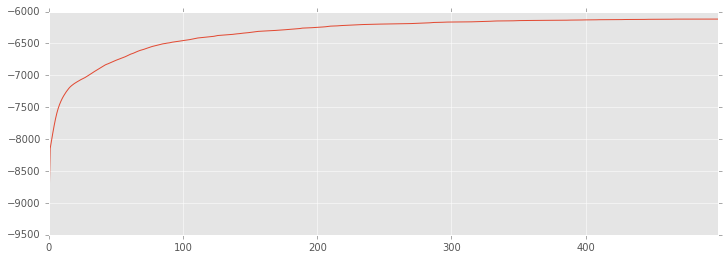

In [18]:
gamma, phi_pq, phi_qp, B, elbos = train_mmsb(X, K, 500)
pd.Series(elbos).plot(figsize=[12,4])
max(elbos), elbos[-1]

# Interaction matrix

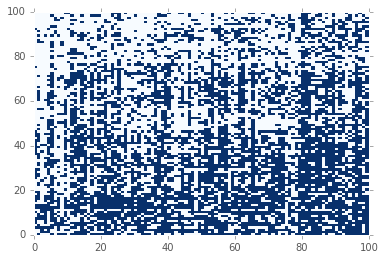

In [17]:
I = pd.DataFrame(get_interactions(X, V))
ptypes = pd.DataFrame(gamma).idxmax()
plt.pcolor(I.ix[ptypes.sort_values().index], cmap='Blues')

# Pi (prototype distributions)

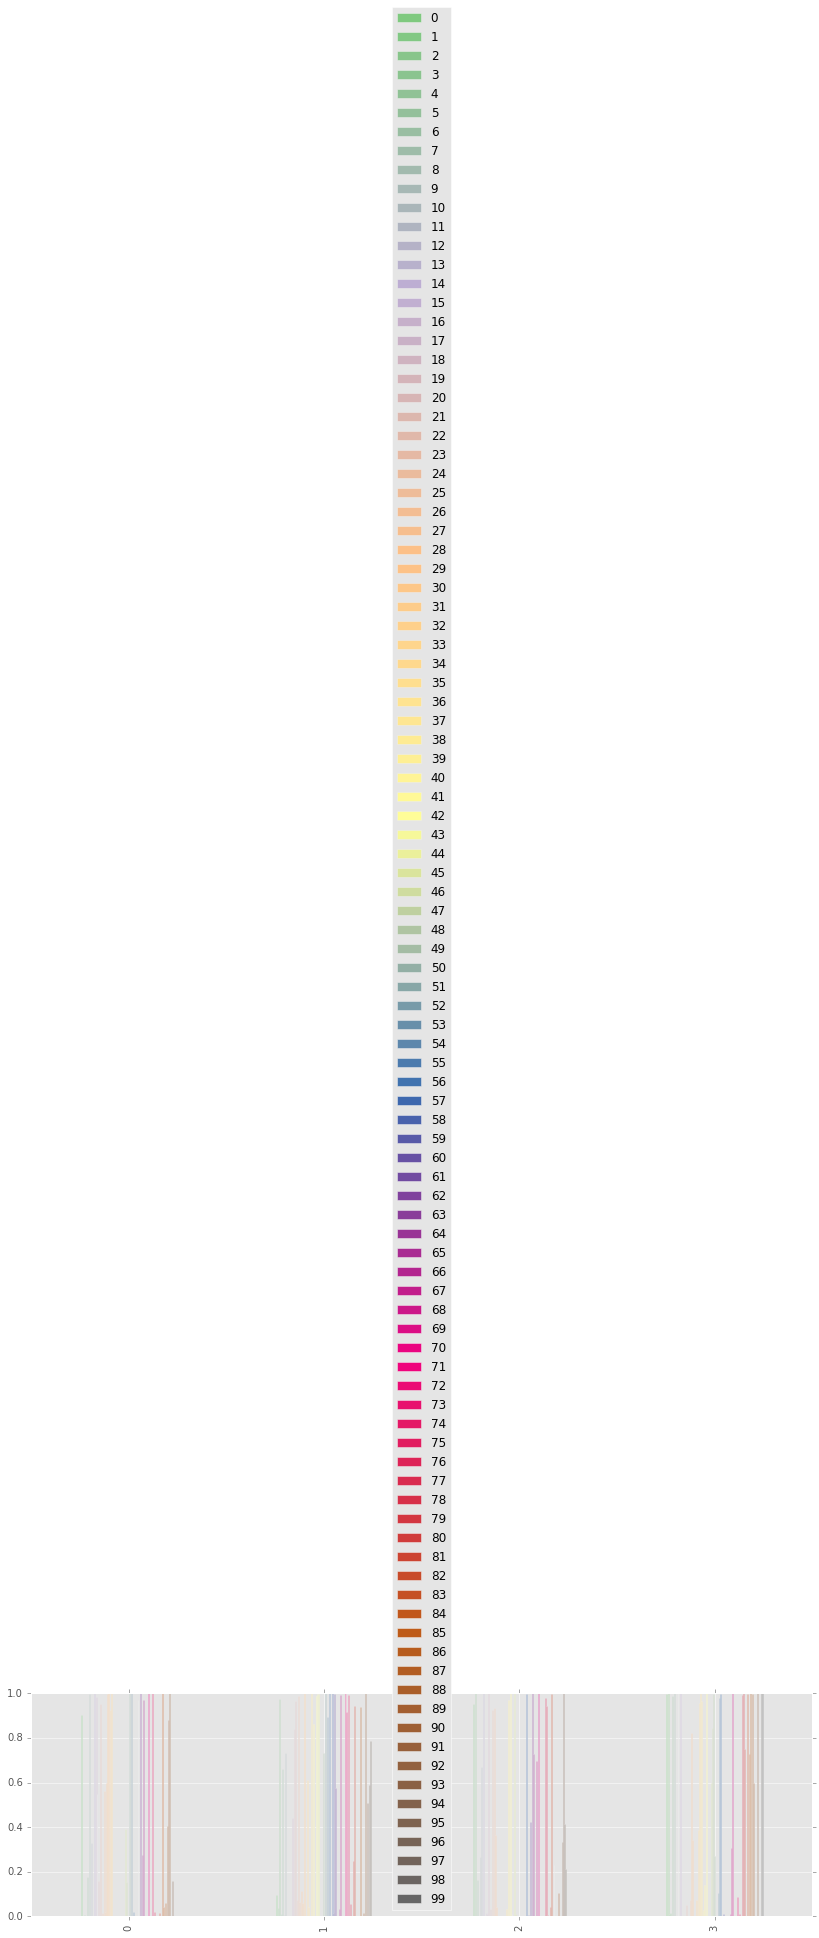

In [11]:
pd.DataFrame(pi).T.plot(kind='bar', cmap='Accent', figsize=[14,4])

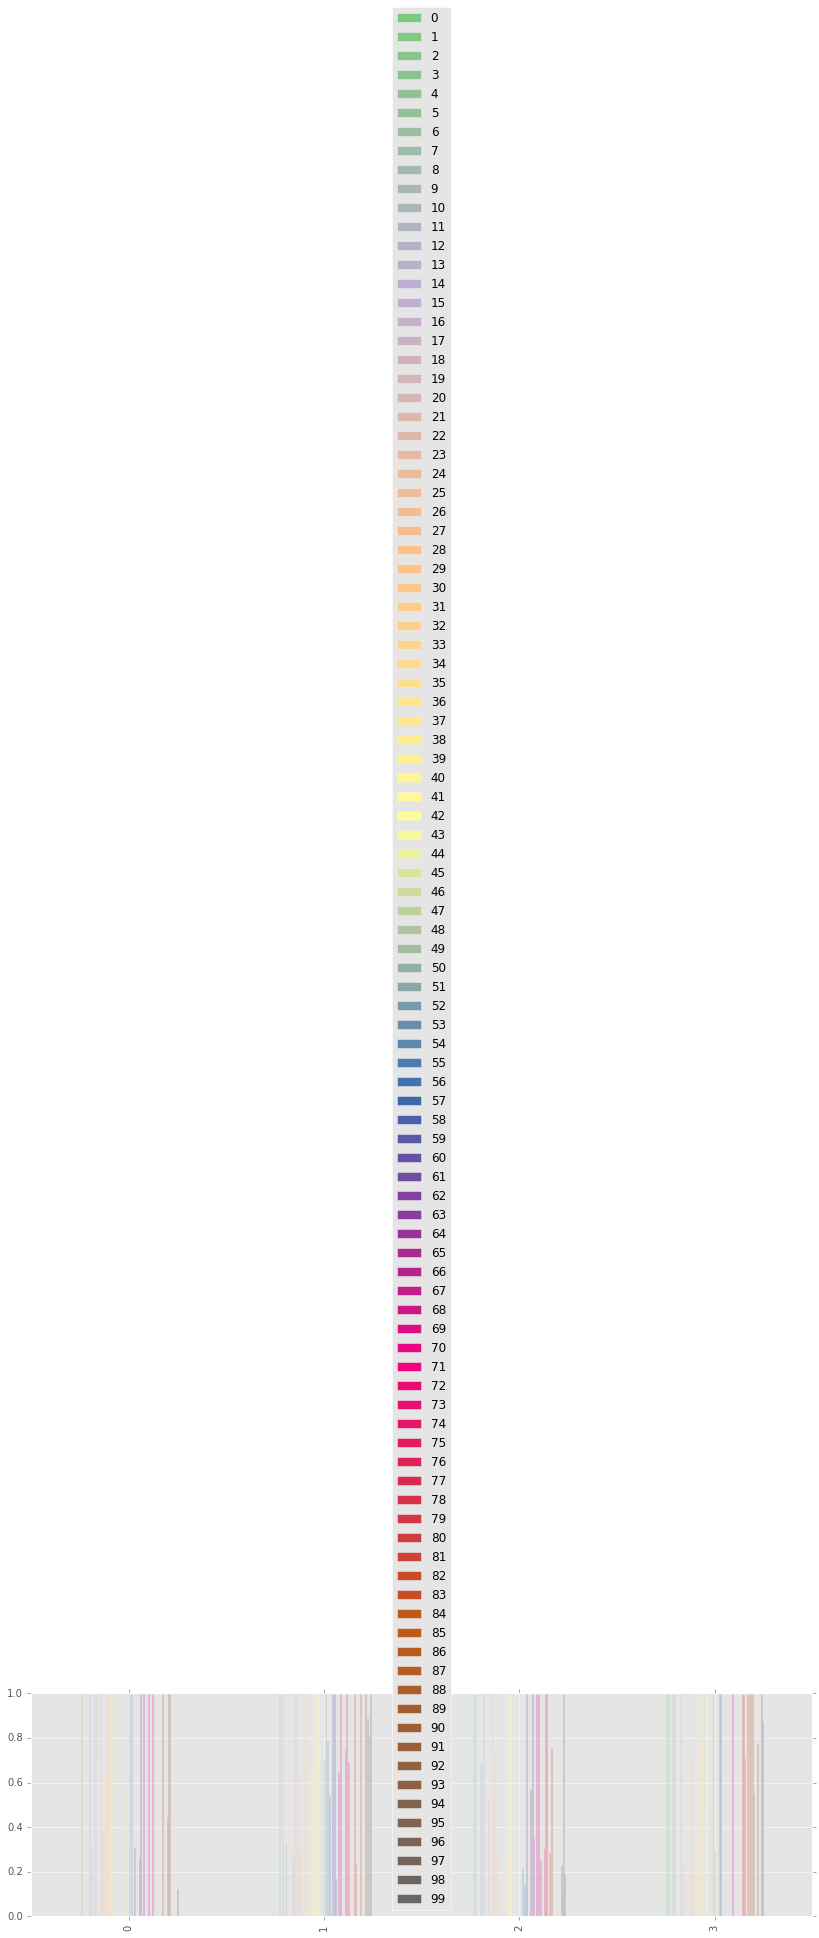

In [12]:
pd.DataFrame(gamma).plot(kind='bar', cmap='Accent', figsize=[14,4])

# B (interaction probabilities)

In [ ]:
pd.DataFrame(B).round(6)